# Genera una rappresentazione grafica dei punti iniziali e del poligono regolare ottimale

Il programma chiede il numero dei lati del poligono *"teorico"* (con centro in (0,0) e inscritto in una circonferenza di raggio
unitario) e lo scostamento massimo di ciascuna coordinata.
Su tale base genera i vertici di un poligono (*"reale"*) le cui coordinate si discostano in modo random da quello teorico.  
Tramite una regressione circolare, calcola centro e raggio della circonferenza ottimale. Questa approssima nel 
modo migliore i vertici del poligono "reale".  
Successivamente determina il poligono geometrico regolare inscritto in tale circonferenza così da minimizzare la somma dei
quadrati delle distanze dai vertici del poligono reale.  
Infine si rappresentano graficamente:
- il poligono teorico iniziale (in trasparenza rosso)
- la circonferenza ottimale (con relativo centro)
- i punti del poligono reale (crocette)
- i vertici e il poligono ottimale

@Lorenzo

Librerie importate

In [19]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

Definizioni delle varie funzioni utilizzate

In [20]:
def calc_R(x, y, xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f(c, x, y):
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()

def least_squares_circle(coords):
    x, y = None, None
    if isinstance(coords, np.ndarray):
        x = coords[:, 0]
        y = coords[:, 1]
    elif isinstance(coords, list):
        x = np.array([point[0] for point in coords])
        y = np.array([point[1] for point in coords])
    else:
        raise Exception(
            "Il parametro 'coords' è di un tipo non supportato: " + str(type(coords)))

    # coordinate del baricentro
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center, _ = optimize.leastsq(f, center_estimate, args = (x, y))
    xc, yc = center
    Ri = calc_R(x, y, *center)
    R = Ri.mean()
    residui = np.sum((Ri - R)**2)
    return xc, yc, R, residui

In [21]:
# Genera il poligono regolare geometrico
def poligonoRegolare(alfa, pars):
    xPolMobile = pars[0] + pars[2]*np.cos(pars[5]*(2*np.pi/pars[6])+alfa+0.2)
    yPolMobile = pars[1] + pars[2]*np.sin(pars[5]*(2*np.pi/pars[6])+alfa+0.2)
    return xPolMobile, yPolMobile

In [22]:
def sommaQuad(alfa, pars):
    dim = len(alfa)
    verticiUtilizzati = len(pars[5])
    xPolMobile, yPolMobile = poligonoRegolare(alfa, pars)
    difxq = (np.broadcast_to(pars[3],(dim,verticiUtilizzati)) - np.transpose(xPolMobile))**2
    difyq = (np.broadcast_to(pars[4],(dim,verticiUtilizzati)) - np.transpose(yPolMobile))**2
    somma = sum(np.transpose(difxq + difyq))
    return somma

In [23]:
def ptsCirconferenzaOttimale(xc,yc,R):
    alfa = np.linspace(-np.pi, np.pi, 180)
    xp = xc + R*np.cos(alfa)
    yp = yc + R*np.sin(alfa)
    return xp, yp

Inizio dell'elaborazione e richiesta del numero di lati del poligono e dello scostamento massimo da associare a ciascuna coordinata dei vertici *teorici*.

In [24]:
centro, raggio = np.array([0,0]), 1
print()
numLati = int(input('inserire il numero di lati del poligono: '))
maxScostamento = float(input("inserire il valore massimo dell'errore (per es. 0.01): "))
ascisseApprox, ordinateApprox = [], []
ascisse, ordinate = [], []
rng = np.random.default_rng()
indiceVertici = np.arange(numLati)
ascisseApprox = centro[0] + raggio*np.cos(2*np.pi*indiceVertici/numLati + maxScostamento*rng.random())
ordinateApprox = centro[0] + raggio*np.sin(2*np.pi*indiceVertici/numLati + maxScostamento*rng.random())
ascisse = centro[0] + raggio*np.cos(2*np.pi*indiceVertici/numLati)
ordinate = centro[0] + raggio*np.sin(2*np.pi*indiceVertici/numLati)

Ricerca delle circonferenza ottimale e del minimo della somma dei quadrati delle distanze tra vertici reali e poligono regolare che li descrive.

In [25]:
xdata = ascisseApprox
ydata = ordinateApprox
coords = np.transpose([xdata, ydata])
xc, yc, r, s = least_squares_circle(coords)
par = [xc, yc, r, xdata, ydata, np.arange(numLati), numLati]
diz = optimize.minimize(sommaQuad, 0, (par))

Istruzioni di carattere grafico

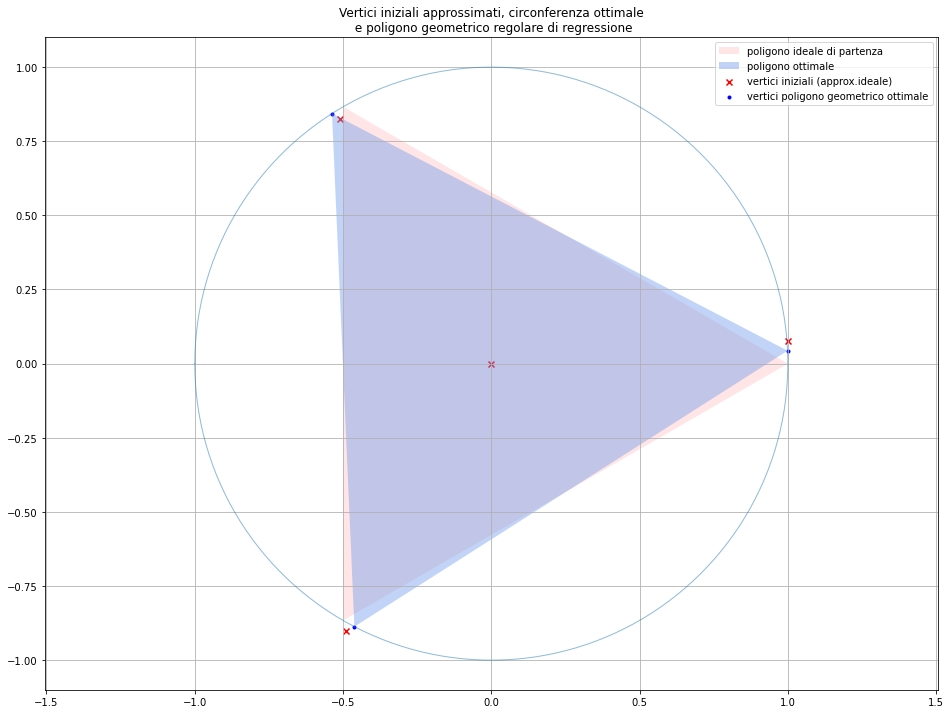

In [26]:
figura = plt.figure(facecolor = 'white')
plt.rcParams['figure.figsize'] = [16, 12]
plt.axis('equal')
plt.grid()
xp, yp = ptsCirconferenzaOttimale(xc, yc, r)
plt.plot(xp, yp, linewidth = 1, alpha = 0.5)
plt.scatter(xc, yc, c = 'red', marker = 'x')
plt.scatter(ascisseApprox, ordinateApprox, c = 'red', label = 'vertici iniziali (approx.ideale)', marker = 'x')
plt.scatter(poligonoRegolare(diz.x[0],par)[0], poligonoRegolare(diz.x[0],par)[1], c = 'blue', label = 'vertici poligono geometrico ottimale', marker = '.')
plt.fill(ascisse, ordinate, facecolor = 'red', alpha = 0.1, label = 'poligono ideale di partenza')
plt.fill(poligonoRegolare(diz.x[0],par)[0], poligonoRegolare(diz.x[0],par)[1], facecolor = 'cornflowerblue', alpha = 0.4, label = 'poligono ottimale')
plt.legend(loc = 'best', labelspacing = 0.5)
plt.title('Vertici iniziali approssimati, circonferenza ottimale\n e poligono geometrico regolare di regressione')
plt.show()